This notebook demonstrates 
the differences between instances of the same network architecture trained on the same data using stochastic gradient descent.

In [1]:
import sys
sys.path.insert(0,'/usr/lib/caffe/python')
sys.path.insert(0,'/home/wcorning/PyLib/protobuf')
import caffe
caffe.set_mode_gpu()
import numpy as np

* The first layer consists of 20 convolutional nodes with 5x5 kernels.
* The second layer performs max pooling in 2x2 blocks.
* The third layer is again convolutional, with 50 nodes having 5x5 kernels.
* The fourth layer is 2x2 max pooling as before.
* The fifth layer is a fully connected layer of 500 nodes.
* The sixth layer is a rectified linear layer, which sets non-positive data equal to zero. This is in-place.
* The sixth layer is another fully connected layer with 10 nodes.
* The final layer gives the error gradient.


In [18]:
nets[0].blobs

OrderedDict([('data', <caffe._caffe.Blob at 0x7f0b06139848>),
             ('conv1', <caffe._caffe.Blob at 0x7f0b06139b18>),
             ('pool1', <caffe._caffe.Blob at 0x7f0b061399b0>),
             ('conv2', <caffe._caffe.Blob at 0x7f0b06139aa0>),
             ('pool2', <caffe._caffe.Blob at 0x7f0b06139938>),
             ('ip1', <caffe._caffe.Blob at 0x7f0b06139b90>),
             ('ip2', <caffe._caffe.Blob at 0x7f0b06139c08>)])

In [23]:
np.concatenate([b.data.flatten() for b in nets[0].blobs.values()]).shape

(19694,)

In [62]:
[k for k in nets[0].blobs if k != 'data']

['conv1', 'pool1', 'conv2', 'pool2', 'ip1', 'ip2']

In [12]:
nets = [caffe.Net('/home/wcorning/Thesis/exp/mnist_replicates/deploy.prototxt',
                  '/home/wcorning/Thesis/exp/mnist_replicates/net{}.caffemodel'.format(i),
                  caffe.TEST) for i in range(20)]

In [199]:
def getActivations(net,imgset):
    res = []
    for img in imgset:
        net.blobs['data'].data[:] = img
        net.forward()
        res.append([net.blobs[k].data.flatten() for k in net.blobs if k != 'data'])
    return np.vstack(res)

In [200]:
def getActivationMatrix(imgset):
    return np.rollaxis(np.dstack([getActivations(net,imgset) for net in nets]),2,0)

In [114]:
import pickle

In [115]:
fobj = open("/home/wcorning/Thesis/exp/data/mnist/mnist.pkl")
data = pickle.load(fobj)
fobj.close()

In [147]:
test_set = [np.reshape(img,[1,1,28,28]) for img in data[2][0]]

In [137]:
len(test_set)

10000

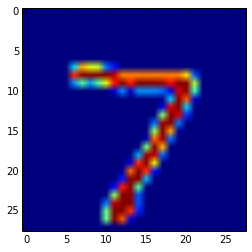

In [136]:
imshow(test_set[0][0][0])

In [149]:
idx = np.random.choice(range(len(test_set)),100)
test_subset = [test_set[i] for i in idx]
len(test_subset)

In [201]:
r = getActivationMatrix(test_subset)

In [202]:
r.shape

(20, 100, 6)

In [203]:
final_activations = r[:,0,-1]

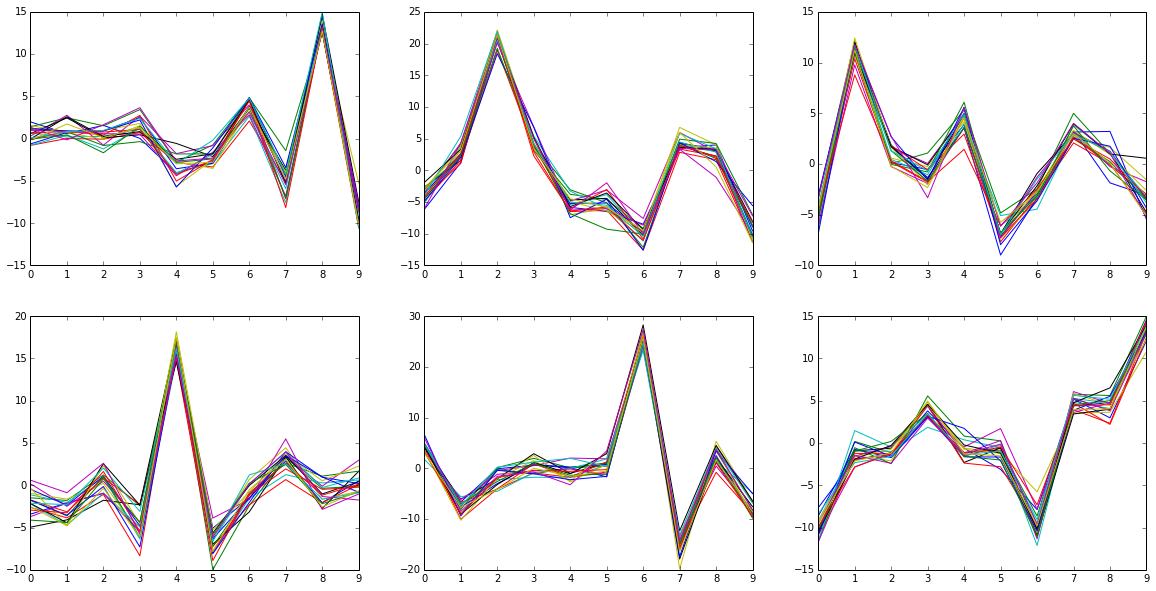

In [206]:
figure(figsize=(20,10))
for i in range(6):
    subplot(2,3,i+1)
    for a in r[:,i,-1]:
        plt.plot(a)
plt.show()

The final-layer activations match up fairly well between retrainings.

---
Let's see what it looks like when we plot the activations for each layer of the same image across all 20 networks.

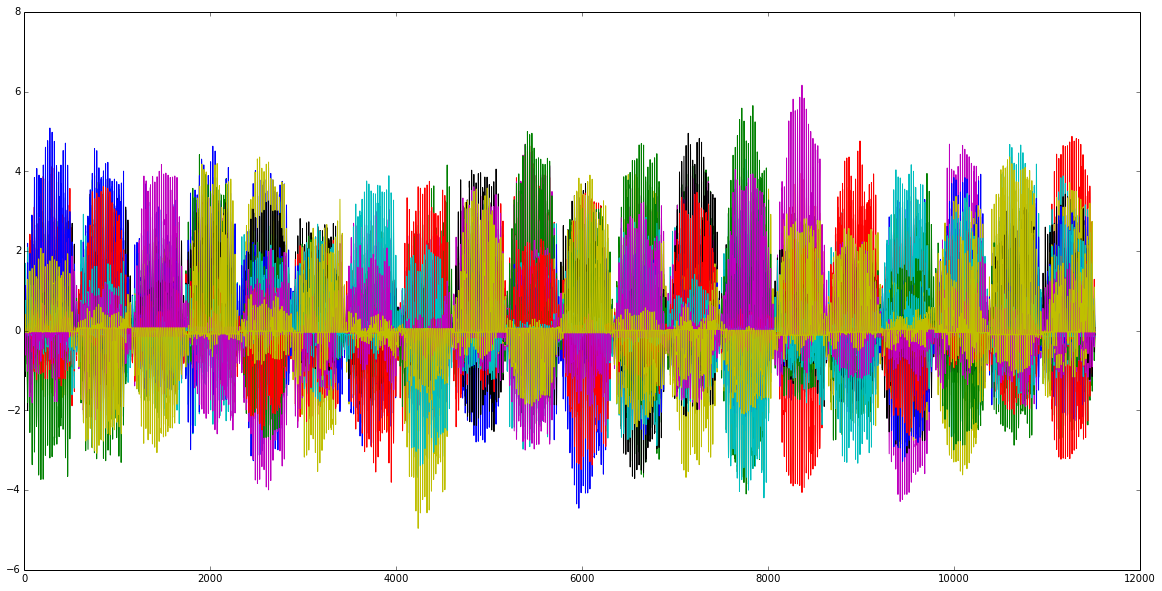

In [238]:
figure(figsize=(20,10))
for a in r[:,0,0]:
    plt.plot(a)
plt.show()

The first convolutional layer displays some interesting patterns. There are 20 distinct activation segments corresponding to the 20 different convolutional nodes. Each segment represents a 24x24 convolutional output.

We can image these convolutional results across the different networks:

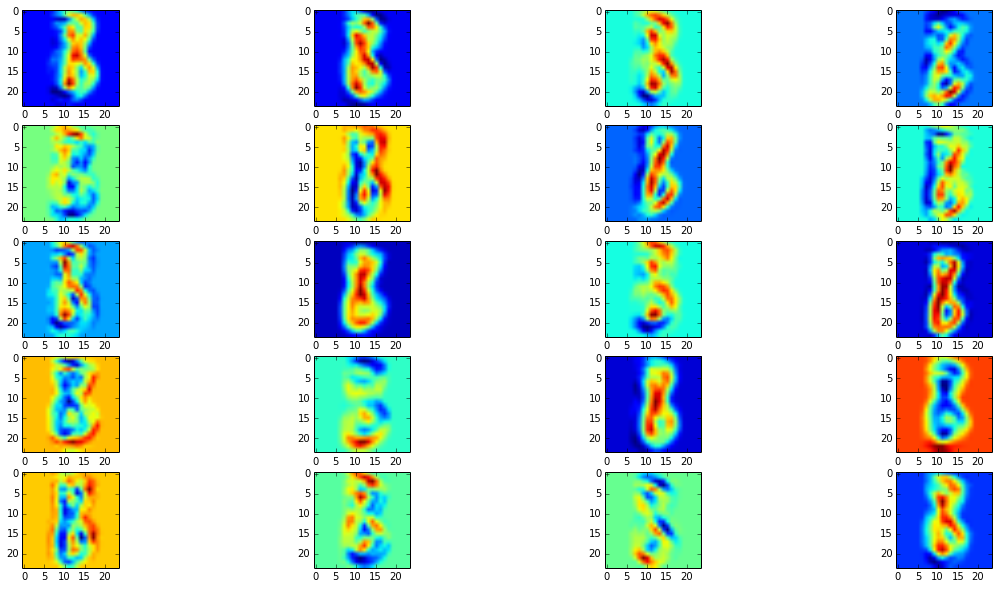

In [224]:
figure(figsize=(20,10))
for i in range(20):
    subplot(5,4,i+1)
    imshow(r[i,0,0][:576].reshape(24,24))
plt.show()

This same block is being used for different convolutions between the networks.

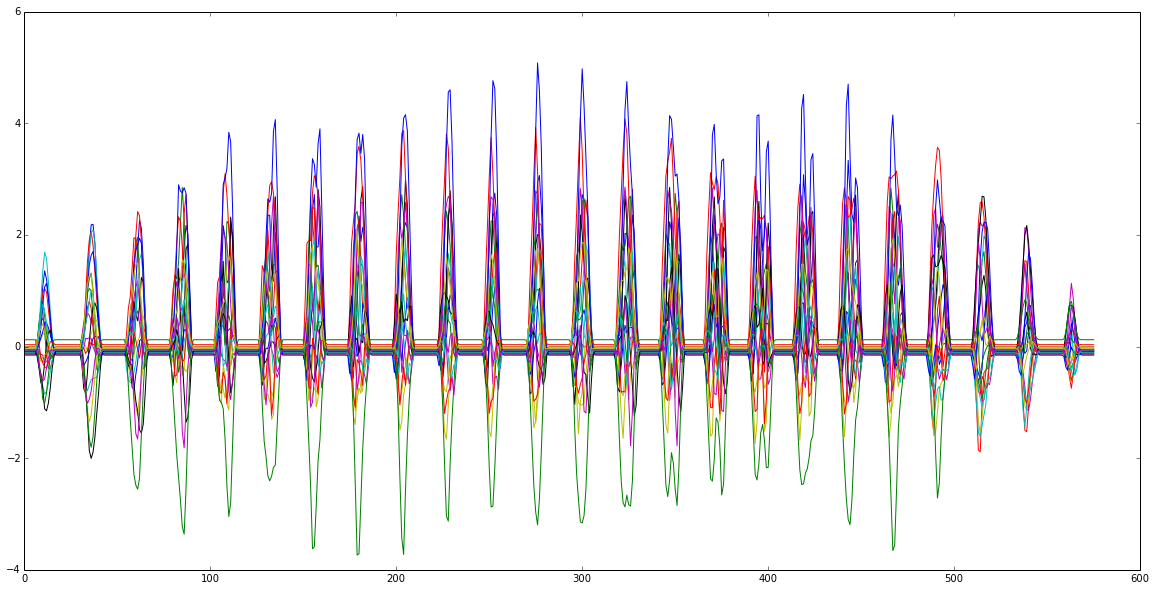

In [240]:
figure(figsize=(20,10))
for a in r[:,0,0]:
    plt.plot(a[:576])
plt.show()

Each block appears to contain 24 spikes of varying magnitude. This is simply the result of the convolution crossing empty patches on each row as it traverses the image.

---

Is there a 1:1 mapping between nodes in each network? That is, have the networks been trained to the same model (with differently ordered nodes), or are they behaving in fundamentally different ways?